In [35]:
#WE DONT HAVE THE PACKAGES SO IT WILL NOT RUN
# General python

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
from Weigfun import Weigfun
#from plateau import plateau
import warnings
warnings.filterwarnings('ignore')

First, we need to build our model. You do this by coding in the following cells. Since we are working with a landscape-driven, semi-distributed model, we need to build each of the landscape units: plateau, hillslope and wetlands. We will start with the hillslope and wetland function. Since the plateau unit is more or less equivalent to the HBVmodel, the code structure is the same as the HVB model, and you do not have to code this part (it is already loaded in the first cell). After that, you can finalize the FlexTopo function. NOTE this is not written in BMI (yet).


In [36]:
#PLATEAU

def plateau_func(timestep, Par, forcing, Fluxes, States ):
	#HBVpareto Calculates values of 3 objective functions for HBV model

	Imax=Par[0]
	Ce=Par[1]
	Sumax=Par[2]
	beta=Par[3]
	Pmax=Par[4]
	Kf=Par[5]

	Qo = forcing['Qo']
	Prec = forcing['Prec']
	Etp = forcing['Etp']


	tmax=len(Prec)
	Si=States[:,0]
	Su=States[:,1]
	Sf=States[:,2]

	Eidt=Fluxes[:,0]
	Eadt=Fluxes[:,1]
	Qfdt=Fluxes[:,2]
	Qusdt=Fluxes[:,3]

	dt=1
	t=timestep


	Pdt=Prec[t]*dt
	Epdt=Etp[t]*dt
	# Interception Reservoir
	if Pdt>0:
		Si[t]=Si[t]+Pdt
		Pedt=max(0,Si[t]-Imax)
		Si[t]=Si[t]-Pedt
		Eidt[t]=0
	else:
	# Evaporation only when there is no rainfall
		Pedt=0
		Eidt[t]=min(Epdt,Si[t])
		Si[t]=Si[t]-Eidt[t]

	if t<tmax-1:
		Si[t+1]=Si[t]


	# Unsaturated Reservoir
	if Pedt>0:
		rho=(Su[t]/Sumax)**beta            
		Su[t]=Su[t]+(1-rho)*Pedt
		Qufdt=rho*Pedt
	else:
		Qufdt=0

	# Transpiration
	Epdt=max(0,Epdt-Eidt[t])
	Eadt[t]=Epdt*(Su[t]/(Sumax*Ce))
	Eadt[t]=min(Eadt[t],Su[t])
	Su[t]=Su[t]-Eadt[t]

	# Percolation
	Qusdt=(Su[t]/Sumax)*Pmax*dt
	Su[t]=Su[t]-min(Qusdt,Su[t])
	if t<tmax-1:
		Su[t+1]=Su[t]

	# Fast Reservoir
	Sf[t]=Sf[t]+Qufdt
	Qfdt[t]= dt*Kf*Sf[t]
	Sf[t]=Sf[t]-min(Qfdt[t],Sf[t])
	if t<tmax-1:
		Sf[t+1]=Sf[t]
	    
	    

	#save output
	States[:,0]=Si
	States[:,1]=Su
	States[:,2]=Sf

	Fluxes[:,0]=Eidt
	Fluxes[:,1]=Eadt
	Fluxes[:,2]=Qfdt
	Fluxes[:,3]=Qusdt

	return(Fluxes, States)

	



In [37]:
#HILLSLOPE
def hillslope_func(timestep, Par, forcing, Fluxes, States):
	# HBVpareto Calculates values of 3 objective functions for HBV model

	I_max = Par[0]
	Ce = Par[1]
	Su_max = Par[2]
	beta = Par[3]
	D = Par[4]
	Kf = Par[5]
	Qo = forcing['Qo']
	Prec = forcing['Prec']
	Etp = forcing['Etp']


	t_max = len(Prec)
	Si = States[:,0]
	Su = States[:,1]
	Sf = States[:,2]

	Ei_dt = Fluxes[:,0]
	Ea_dt = Fluxes[:,1]
	Qf_dt = Fluxes[:,2]
	Qus_dt = Fluxes[:,3]

	dt = 1
	i = timestep
	P_dt = Prec[i] * dt
	Ep_dt = Etp[i] * dt
    
	'''UPDATE'''
	# Interception Reservoir
	if P_dt > 0:
		Si[i] = Si[i] + P_dt*dt
		Pe_dt = np.maximum(0, (Si[i] - I_max) / dt)
		Si[i] = Si[i] - Pe_dt*dt
		Ei_dt[i] = 0
              
	else:
		Pe_dt = np.maximum(0, (Si[i] - I_max)/dt)
		Ei_dt[i] = np.minimum(Ep_dt, Si[i] / dt)
		Si[i] = Si[i] - Pe_dt*dt - Ei_dt[i]*dt      
	if i < t_max-1:
		Si[i+1] = Si[i]		  

	# Unsaturated Reservoir
	
	
	
	if Pe_dt > 0:
		Cr = (Su[i] / Su_max) ** beta
		Qiu_dt = (1 - Cr) * Pe_dt # flux from Ir to Ur
		Su[i] = Su[i] + Qiu_dt*dt
		Quf_dt = Cr * Pe_dt
	else:
		Quf_dt = 0

	# Transpiration
	Ep_dt = max(0, Ep_dt - Ei_dt[i])
	Ea_dt[i] = Ep_dt * (Su[i] / (Su_max * Ce))
	Ea_dt[i] = min(Su[i] / dt, Ea_dt[i])
	Su[i] = Su[i] - Ea_dt[i]*dt

	# Preferential Percolation
	Qus_dt = D * Quf_dt

	# Fast Reservoir
	Sf[i] = Sf[i] + (1-D) * Quf_dt
	Qf_dt[i] = dt * Kf * Sf[i]
	Sf[i] = Sf[i] - Qf_dt[i]*dt

	# Save output
	States[:,0] = Si
	States[:,1] = Su
	States[:,2] = Sf

	Fluxes[:,0] = Ei_dt
	Fluxes[:,1] = Ea_dt
	Fluxes[:,2] = Qf_dt
	Fluxes[:,3] = Qus_dt

	return(Fluxes, States)
    
	
		
	

In [38]:
#WETLANDS
def wetland_func(timestep, Par, forcing, Fluxes, States, Ss, landscape_per):
	# HBVpareto Calculates values of 3 objective functions for HBV model

	I_max = Par[0]
	Ce = Par[1]
	Su_max = Par[2]
	beta = Par[3]
	C_max = Par[4]
	Kf = Par[5]

	Qo = forcing['Qo']
	Prec = forcing['Prec']
	Etp = forcing['Etp']


	t_max = len(Prec)
	Si = States[:,0]
	Su = States[:,1]
	Sf = States[:,2]

	Ei_dt = Fluxes[:,0]
	Ea_dt = Fluxes[:,1]
	Qf_dt = Fluxes[:,2]

	dt = 1
	i = timestep

	P_dt = Prec[i] * dt
	Ep_dt = Etp[i] * dt
	'''UPDATE'''
	# Interception Reservoir
	if P_dt > 0:
		Si[i] = Si[i] + P_dt*dt
		Pe_dt = np.maximum(0, (Si[i] - I_max) / dt)
		Si[i] = Si[i] - Pe_dt*dt
		Ei_dt[i] = 0
	else:
        # Evaporation only when there is no rainfall
		Pe_dt = np.maximum(0, (Si[i] - I_max) / dt) #is zero, because of no rainfall
		Ei_dt[i] = np.minimum(Ep_dt, Si[i] / dt)
		Si[i] = Si[i] - Pe_dt*dt - Ei_dt[i]*dt
	if i < t_max-1:
		Si[i+1] = Si[i]

	'''UPDATE'''
	# Unsaturated Reservoir

	if Pe_dt > 0:
		Cr = (Su[i] / Su_max) ** beta
		Qiu_dt = (1 - Cr) * Pe_dt # flux from Ir to Ur
		Su[i] = Su[i] + Qiu_dt*dt
		Quf_dt = Cr * Pe_dt #flux from Su to Sf
	else:
		Quf_dt = 0
	

	'''UPDATE'''
	# Transpiration
	Ep_dt = max(0, Ep_dt - Ei_dt[i])
	Ea_dt[i] = Ep_dt * (Su[i] / (Su_max * Ce))
	Ea_dt[i] = min(Su[i] / dt, Ea_dt[i])
	Su[i] = Su[i] - Ea_dt[i]*dt

	'''UPDATE'''
	# Capillary rise
	Qr_dt = (1-Su[i]/Su_max) * C_max
	Qr_dt = min(Qr_dt, Ss[i]*landscape_per/dt )#check if the groundwater has enough water (note: you need to use the landscape percentage!!!)

	if ((Su[i] + Qr_dt) > Su_max):
		Qr_dt = Su_max - Su[i]

	'''UPDATE'''
	Su[i] = Su[i] + Qr_dt*dt
	Ss[i] = Ss[i] - Qr_dt*dt * landscape_per

	if i < t_max - 1:
		Su[i+1] = Su[i]

	'''UPDATE'''
	# Fast Reservoir
	Sf[i] = Sf[i] + Quf_dt*dt
	Qf_dt = dt * Kf * Sf[i]
	Sf[i] = Sf[i] - Qf_dt*dt
	if i < t_max-1:
		Sf[i+1] = Sf[i]


	# Save output
	States[:,0] = Si
	States[:,1] = Su
	States[:,2] = Sf

	Fluxes[:,0] = Ei_dt
	Fluxes[:,1] = Ea_dt
	Fluxes[:,2] = Qf_dt

	return(Fluxes, States, Ss)


In [39]:
def FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, forcing, landscapes):

	# Parameters and constants
	T_lag = ParCatchment[1]
	Ks = ParCatchment[0]
	dt = 1
	t_max = len(forcing['Qo'])

	# Initialize states
	States_plateau = np.zeros((t_max,3))
	States_hillslope = np.zeros((t_max,3))
	States_wetland = np.zeros((t_max,3))
	Ss = np.zeros((t_max,1))

	# Initialize fluxes
	Fluxes_plateau = np.zeros((t_max,4))
	Fluxes_hillslope = np.zeros((t_max,4))
	Fluxes_wetland = np.zeros((t_max,3))
	Qs_dt = np.zeros(t_max)
	Q_tot_dt = np.zeros(t_max)

	# Loop over time
	for t in range(0,t_max):

		# Plateau
		Fluxes_plateau, States_plateau = plateau_func(t, ParPlateau, forcing, Fluxes_plateau, States_plateau)
		# Hillslope
		Fluxes_hillslope, States_hillslope = hillslope_func(t, ParHillslope, forcing, Fluxes_hillslope, States_hillslope)

		# Wetland
		Fluxes_wetland, States_wetland, Ss = wetland_func(t, ParWetland, forcing, Fluxes_wetland, States_wetland, Ss, landscapes[2])

		# Slow Reservoir
		'''UPDATE'''
		Ss[t] = Ss[t] + Fluxes_plateau[t,3]*dt * landscapes[0] + Fluxes_hillslope[t,3]*dt * landscapes[1]
		Qs_dt = dt * Ks * Ss[t]
		Ss[t] = Ss[t] - min(Qs_dt,Ss[t])
		if t < t_max - 1:
			Ss[t+1] = Ss[t]

		'''UPDATE'''
		Q_tot_dt[t] = Qs_dt + Fluxes_plateau[t,2] * landscapes[0] + Fluxes_hillslope[t,2] * landscapes[1] +  Fluxes_wetland[t,2] * landscapes[2]

	# Offset Q
	weigths = Weigfun(T_lag)

	Qm = np.convolve(Q_tot_dt, weigths)
	Qm = Qm[0:t_max]

	return(Qm)

In [40]:
DEM = np.genfromtxt('wark_data/dem.asc',  dtype=float, autostrip=True)
slope = np.genfromtxt('wark_data/slope.asc',  dtype=float, autostrip=True)
hand = np.genfromtxt('wark_data/HAND.asc',  dtype=float, autostrip=True)
basin = np.genfromtxt('wark_data/basin.asc',  dtype=float, autostrip=True)

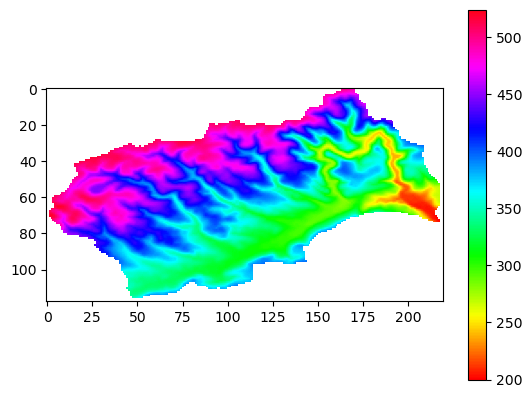

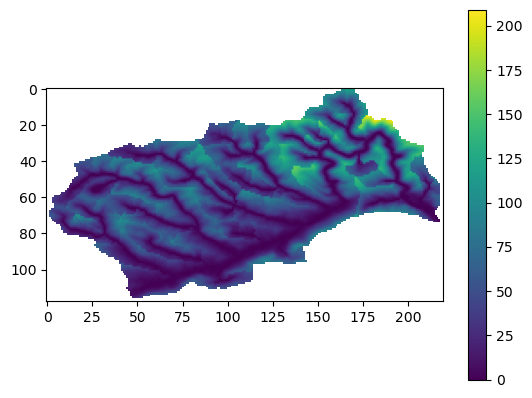

In [41]:
# plot DEM
plt.figure(1)
DEM[DEM==-9999]=np.nan
plt.imshow(DEM, cmap='hsv')
plt.colorbar()

'''UPDATE'''
# plot HAND
plt.figure(2)
hand[hand==-9999]=np.nan
plt.imshow(hand)
plt.colorbar()
plt.show()

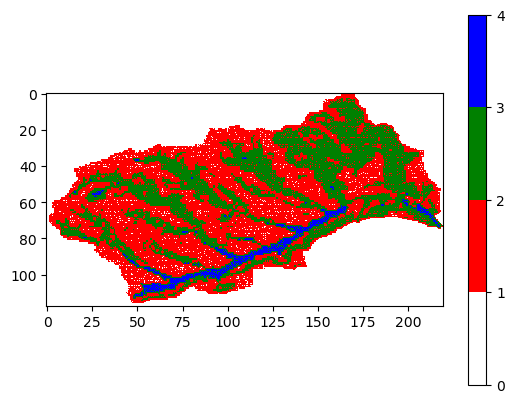

In [42]:
'''UPDATE'''
# Make landscape classification
hillslope = np.array(slope) > 11
plateau = (np.array(hand) > 5) & (np.array(slope) <= 11)
wetland = (np.array(hand) <= 5) & (np.array(slope) <= 11)
basin = np.array(basin) > 0

'''UPDATE'''
hillslope_per = float(np.sum(hillslope))/float(np.sum(basin))
wetland_per = float(np.sum(wetland))/float(np.sum(basin))
plateau_per = float(np.sum(plateau))/float(np.sum(basin))

landscapes=np.zeros((118,220))
landscapes[plateau] = 1
landscapes[hillslope] = 2
landscapes[wetland] = 3

# Plot landscapes
cmap = mpl.colors.ListedColormap(['white', 'red', 'green', 'blue'])
bounds = [0, 1, 2, 3, 4]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(3)
plt.imshow(landscapes, cmap=cmap, norm=norm)
plt.colorbar()
plt.show()

In [43]:
# Assuming the text file has three columns: year, month, day
# Use pandas to read the text file
df = pd.read_csv('wark_data/forcingWark.txt', sep='\s+', header=None, names=['month', 'day', 'year', 'Qo', 'Prec', 'Etp'], dtype=float)

# Create a new column that combines the year, month, and day into a datetime object
df['date'] = pd.to_datetime(df[['day', 'month', 'year']])

forcing = df
forcing.head()

,month,day,year,Qo,Prec,Etp,date
0,8.0,1.0,2001.0,0.09290,0.0,4.002,2001-08-01
1,8.0,2.0,2001.0,0.09086,1.0,4.200,2001-08-02
2,8.0,3.0,2001.0,0.10281,1.5,3.800,2001-08-03
3,8.0,4.0,2001.0,0.10328,1.7,3.000,2001-08-04
4,8.0,5.0,2001.0,0.10178,4.9,2.900,2001-08-05


In [44]:
#      I_max Ce Su_max beta Pmax    Kf  
ParPlateau   = np.array([3.2, 0.50, 17.40, 0.95, 1.76, 0.91])   
                  #      I_max Ce Su_max beta D     Kf  
ParHillslope = np.array([3.25, 0.50, 321.99, 0.99, 0.4, 0.97])
                  #      I_max Ce Su_max beta C_max     Kf  
ParWetland   = np.array([9.94, 0.50, 53.25, 0.70, 0.65, 0.45])
              # Ks T_lag
ParCatchment = np.array([0.0281, 2.21])

'''UPDATE'''
# Landscape percentages
landscape_per = np.array([plateau_per, hillslope_per, wetland_per])

Text(0, 0.5, 'Flow')

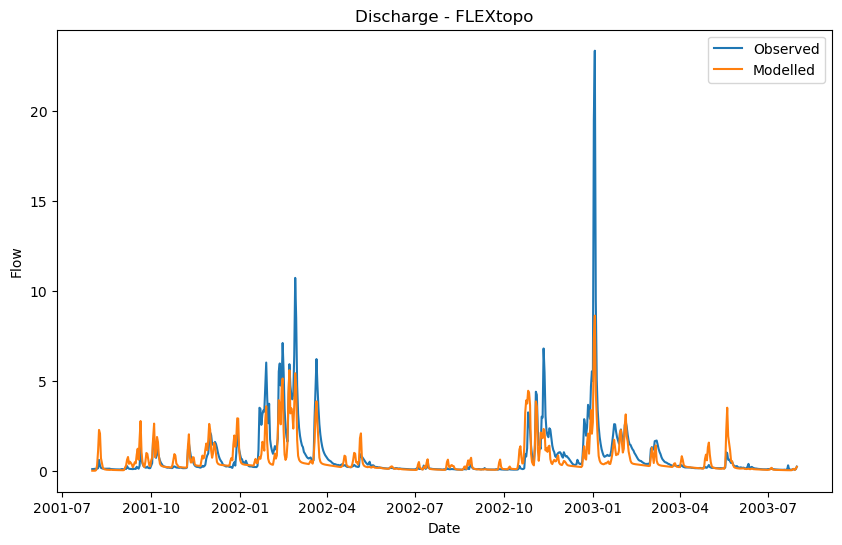

In [45]:
Qm = FLEXtopo(ParPlateau, ParHillslope, ParWetland, ParCatchment, forcing, landscape_per)
Qo = forcing['Qo']	

fig, ax = plt.subplots(figsize=(10,6))

ax.plot(df['date'], Qo, label='Observed')
ax.plot(df['date'], Qm, label='Modelled')
ax.legend()
ax.set_title('Discharge - FLEXtopo')

ax.set_xlabel('Date')
ax.set_ylabel('Flow')